# Narrative Communities and Emotional Geography in a Lord of the Rings Wiki Network
 (Group 9) — [02805] Social Graphs and Interactions 2025

**Authors:**
* Ravi Kumar (s242513)
* Zohair Khan (s242544)
* Arham Aziz Noman (s250173)

**Due date:** 10th Dec 2025  

---

## Introduction
In this notebook, we present a comprehensive analysis of the Lord of the Rings Character Network, a graph in which nodes are characters and edges are hyperlinks between their wiki pages. Our goal is to test the hypothesis that the network's structural communities are defined by plot dynamics and chronology rather than by simple political or racial allegiance.

In [1]:
!pip install networkx pandas numpy matplotlib powerlaw python-louvain wordcloud nltk requests tqdm backbone-network

In [2]:
import pandas as pd, numpy as np, networkx as nx, matplotlib.pyplot as plt
import powerlaw, requests, nltk, re
from wordcloud import WordCloud
from community import community_louvain
from collections import Counter, defaultdict
from nltk.tokenize import word_tokenize
from tqdm.notebook import tqdm
import io
import math
import time
from networkx.algorithms import community
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

nltk.download('punkt')
nltk.download('punkt_tab')
nltk.download('popular', quiet=True)

plt.style.use("seaborn-v0_8-whitegrid")

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


## Part 1: Allegiance vs. Structure


This section loads our pre-cleaned dataset, performs final data normalization on attributes, and constructs the necessary NetworkX graphs (`G` for directed analysis, `G_analysis` for undirected community analysis).


### 1.1 Defining the Ground Truth: Allegiance Modularity (*M*<sub>*allegiance*</sub>)

**Question**: *What is the modularity of the network when partitioned by the manually defined allegiance groups?*

The first step in our analysis is to establish a Ground Truth Modularity by partitioning the network based on the allegiance_group attribute we created (e.g., Free Peoples, Servants of Evil). This attribute represents the clear political/factional divisions of Middle-earth. The resulting modularity score, *M*<sub>*allegiance*</sub> , serves as our baseline to test how well these external, known labels align with the network's internal link structure.

In [3]:
url = "https://raw.githubusercontent.com/ravioad/social-graphs-contents/refs/heads/main/lotr_dataset_final.csv"

try:
    response = requests.get(url)
    response.raise_for_status()
    data_in_memory = io.BytesIO(response.content)
    df = pd.read_csv(data_in_memory)
    print(f"\nLoaded dataset with {len(df)} characters.")
except Exception as e:
    print(f"CRITICAL ERROR: Failed to load dataset from URL: {e}")
    exit()

print("Normalizing 'race' and defining 'allegiance' groups...")

df.loc[df['race'].str.contains('Maia', case=False, na=False), 'race'] = 'Maiar'
df.loc[df['race'].str.contains('Valar', case=False, na=False), 'race'] = 'Maiar'
df.loc[df['race'].str.contains('Man', case=False, na=False), 'race'] = 'Man'
df.loc[df['race'].str.contains('Númenórean', case=False, na=False), 'race'] = 'Man'

def normalize_allegiance(allegiance_str):
    if not isinstance(allegiance_str, str): return 'Neutral/Unknown'
    allegiance_str = allegiance_str.lower()

    if 'fellowship' in allegiance_str or 'free people' in allegiance_str or 'gondor' in allegiance_str or 'rohan' in allegiance_str or 'elrond' in allegiance_str:
        return 'Free Peoples'
    if 'sauron' in allegiance_str or 'morgoth' in allegiance_str or 'orc' in allegiance_str or 'servant' in allegiance_str or 'ringwraith' in allegiance_str:
        return 'Servants of Evil'
    if 'elf' in allegiance_str or 'noldor' in allegiance_str or 'sindar' in allegiance_str or 'lothlorien' in allegiance_str or 'lindon' in allegiance_str:
        return 'Elvish Factions'
    if 'dwarf' in allegiance_str or 'erebor' in allegiance_str or 'khazad' in allegiance_str:
        return 'Dwarven Factions'
    if 'hobbit' in allegiance_str or 'shire' in allegiance_str:
        return 'Hobbit Factions'

    return 'Neutral/Unknown'

df['allegiance_group'] = df['allegiance'].apply(normalize_allegiance)

G = nx.DiGraph()
G_undirected = nx.Graph()
content_cache = {}

print("Building network and populating node attributes...")

for index, row in df.iterrows():
    char_name = row['character_name']

    # Add node with all attributes (allegiance, race, wikitext, etc.)
    G.add_node(char_name, race=row['race'], allegiance=row['allegiance_group'], wikitext=row['wikitext_content'])
    G_undirected.add_node(char_name, race=row['race'], allegiance=row['allegiance_group'])

    content_cache[char_name] = row['wikitext_content']

for index, row in df.iterrows():
    source_character = row['character_name']
    if isinstance(row['outgoing_links'], str):
        target_characters = row['outgoing_links'].split(';')
        for target_character in target_characters:
            if target_character in G:
                G.add_edge(source_character, target_character)
                G_undirected.add_edge(source_character, target_character)

G_analysis = G_undirected.copy()

print(f"Final Directed Graph Built: {G.number_of_nodes()} nodes, {G.number_of_edges()} links.")
print(f"Final Undirected Graph Built (G_analysis): {G_analysis.number_of_nodes()} nodes, {G_analysis.number_of_edges()} links.")


Loaded dataset with 585 characters.
Normalizing 'race' and defining 'allegiance' groups...
Building network and populating node attributes...
Final Directed Graph Built: 585 nodes, 4641 links.
Final Undirected Graph Built (G_analysis): 585 nodes, 3108 links.


In [4]:
print("\n--- Running 1.1: Allegiance Modularity (Ground Truth) ---")
# Get the list of all unique allegiance groups
allegiance_groups = list(nx.get_node_attributes(G_analysis, 'allegiance').values())
unique_allegiances = list(set(allegiance_groups))

allegiance_partition = []
for group in unique_allegiances:
    nodes_in_group = [node for node, data in G_analysis.nodes(data=True) if data.get('allegiance') == group]
    if nodes_in_group:
        allegiance_partition.append(set(nodes_in_group))

M_allegiance = community.modularity(G_analysis, allegiance_partition)

print(f"Number of allegiance groups (communities): {len(allegiance_partition)}")
print(f"Modularity of the Allegiance Partition (M_allegiance): {M_allegiance:.4f}")


--- Running 1.1: Allegiance Modularity (Ground Truth) ---
Number of allegiance groups (communities): 5
Modularity of the Allegiance Partition (M_allegiance): 0.0369


**Results:**
The partitioning process yielded **5 allegiance groups**. The calculated modularity for this partition is:

$$
M_{\text{allegiance}} = 0.0369
$$

**Interpretation:**
The modularity score of **0.0369** is extremely close to zero, which indicates that the network partitioned by political and racial allegiance is no better than a random division. This is a significant preliminary finding. It suggests that the vast majority of links between characters are not driven by simple allegiance (e.g., a Hobbit is not exclusively linking to other Hobbits). This weak structural signal for external labels strongly suggests that the true communities in the network must be defined by factors other than just factional loyalty.


### 1.2 Optimal Structural Modularity (*M*<sub>*louvain*</sub>)

**Question**: *Can an algorithm find a better community structure in the network? If so, how does its modularity score compare to the one based on allegiances?*

Since the allegiance-based partition yielded a modularity close to zero, we now turn to the Louvain algorithm to find the community structure that exists naturally within the network's links. The Louvain algorithm iteratively optimizes the modularity score, meaning the partition it finds should represent the best possible grouping of nodes based purely on connectivity. Comparing this result (*M*<sub>*louvain*</sub>) to our baseline *M*<sub>*allegiance*</sub> will prove how much structural coherence is hidden behind the political labels.

In [5]:
print("Running the Louvain algorithm to detect optimal structural communities...")

louvain_partition = community.louvain_communities(G_analysis, seed=42)
num_communities = len(louvain_partition)

M_louvain = community.modularity(G_analysis, louvain_partition)

print(f"Louvain algorithm found {num_communities} communities.")
print(f"Modularity of the Louvain Partition (M_louvain): {M_louvain:.4f}")

louvain_partition_sorted = sorted(louvain_partition, key=len, reverse=True)

Running the Louvain algorithm to detect optimal structural communities...
Louvain algorithm found 21 communities.
Modularity of the Louvain Partition (M_louvain): 0.6303


The resulting modularity for this structural partition is:
$$
M_{\text{louvain}} = 0.6303
$$

**Interpretation:**

The comparison between the two modularity scores is the core finding of our project:
*   **Allegiance Modularity** (*M*<sub>*allegiance*</sub>): 0.0369

*   **Structural Modularity** (*M*<sub>*louvain*</sub>): 0.6303


The structural partition's score is over 17 times higher than the allegiance-based score. This result is highly significant.
This proves that the network has a robust and well-defined community structure that is almost completely invisible when only using high-level political/factional labels. The hyperlinks between characters are not driven by simple allegiance (which would result in a score close to zero), but by a much finer-grained, more complex set of interactions, which the Louvain algorithm has successfully uncovered.

This sets the stage for our entire paper, arguing that the network's structure is determined by plot dynamics and chronology, rather than a simple good-vs-evil alignment.

### 1.3: Comparing Partitions: The Confusion Matrix

**Question**: *What does the Confusion Matrix reveal about the overlap between the structural communities and the political/racial allegiance groups?*

We use the Confusion Matrix (Matrix `D`) to quantitatively compare our two partitions. We will compare our **5 normalized Allegiance Groups** against the **5 Largest Structural Communities** found by Louvain. The value in each cell `D(i,j)` represents the number of characters who belong to Allegiance `i` AND Community `j`. A strong diagonal in the matrix would indicate good alignment, while a highly distributed matrix proves poor alignment.

In [6]:
# Get the list of all unique allegiance groups names directly from the attributes
allegiance_group_names = sorted(list(set(nx.get_node_attributes(G_analysis, 'allegiance').values())))

# We used the 5 LARGEST structural communities as columns (as 21 is too many for a matrix)
louvain_partition_sorted = sorted(louvain_partition, key=len, reverse=True)
top_5_communities = louvain_partition_sorted[:5]

print(f"Allegiance Groups (Rows): {len(allegiance_group_names)}")
print(f"Largest Structural Communities (Cols): {len(top_5_communities)}")


node_to_comm_id = {}
for i, comm_nodes in enumerate(top_5_communities):
    for node in comm_nodes:
        node_to_comm_id[node] = f'Comm {i}'

matrix_d = pd.DataFrame(0, index=allegiance_group_names, columns=[f'Comm {i}' for i in range(5)])

for node, data in G_analysis.nodes(data=True):
    allegiance = data.get('allegiance')
    # Check if the node belongs to one of the 5 allegiance groups we are using as rows
    if allegiance in allegiance_group_names:
        comm_id = node_to_comm_id.get(node)
        # Check if the node belongs to one of the top 5 structural communities
        if comm_id:
            matrix_d.loc[allegiance, comm_id] += 1

print("\n--- Confusion Matrix (Matrix D): Allegiance Groups vs. Structural Communities ---")
print(matrix_d.to_string())

Allegiance Groups (Rows): 5
Largest Structural Communities (Cols): 5

--- Confusion Matrix (Matrix D): Allegiance Groups vs. Structural Communities ---
                  Comm 0  Comm 1  Comm 2  Comm 3  Comm 4
Dwarven Factions       0       1       0       0       0
Free Peoples           2       1       8       1       0
Hobbit Factions        0       0       0       4       0
Neutral/Unknown      116      70      55      61      57
Servants of Evil      11       4      11       0       0


**Interpretation:**

The Confusion Matrix provides the final piece of evidence supporting our core argument. The matrix is dominated by the Neutral/Unknown allegiance group, which is expected since it includes many characters without clear factional ties (e.g., distant Hobbits, ancient Elves). To reveal the true pattern, we must analyze the distribution of the known factions.

When examining the known allegiances, a very clear pattern emerges: the structural communities found by Louvain are not aligned with the initial allegiance groups.

*  Free Peoples (12 members): These are the core protagonists. They are spread across Comm 0 (2 members), Comm 1 (1 member), and Comm 2 (8 members), showing no single community represents the "Fellowship" group. The largest concentration is in Comm 2.
*  Servants of Evil (26 members): This group is highly distributed across Comm 0 (11 members), Comm 1 (4 members), and Comm 2 (11 members). Again, no single community is a pure "Evil" faction.
*  Hobbit Factions (4 members): These are entirely isolated in Comm 3 (4 members).

The conclusion is strong: no single structural community maps cleanly to a political allegiance. For example, Comm 2 contains the largest number of Free Peoples (8) but also a large number of Servants of Evil (11). This strongly supports our hypothesis that the structural communities are based on plot proximity or chronological events (e.g., characters involved in the events of the Third Age) rather than simple factional allegiance.

In [7]:
print("\n--- Filtered Confusion Matrix (Excluding Neutral/Unknown) ---")

matrix_d_filtered = matrix_d.drop(index='Neutral/Unknown')

matrix_d_filtered.loc['TOTAL KNOWN'] = matrix_d_filtered.sum()

print(matrix_d_filtered.to_string())


--- Filtered Confusion Matrix (Excluding Neutral/Unknown) ---
                  Comm 0  Comm 1  Comm 2  Comm 3  Comm 4
Dwarven Factions       0       1       0       0       0
Free Peoples           2       1       8       1       0
Hobbit Factions        0       0       0       4       0
Servants of Evil      11       4      11       0       0
TOTAL KNOWN           13       6      19       5       0


## Part 2: Thematic Analysis (TF-IDF)


In this section, we apply Natural Language Processing (NLP) to the textual content of the character pages to understand the themes and topics that define the structural communities found in Part 1. This analysis provides the final, non-network evidence needed to assign a definitive identity (plot event, chronology, etc.) to each community.

### 2.1 Calculating and Visualizing TF-IDF

TF-IDF is a statistical measure that identifies the unique vocabulary most characteristic of a document in a large collection. By calculating the score (`TF×IDF`), we ensure that common, generic words are penalized, and only those terms uniquely important to a specific community rise to the top. This analysis provides the direct textual evidence required to assign a thematic identity (e.g., plot event, time period, or geography) to each structural community.

In [8]:
stop_words = set(stopwords.words('english'))
stop_words.update(['ref', 'http', 'www', 'com', 'org', 'html', 'title', 'url', 'date', 'access', 'retrieved', 'archived', 'web', 'cite', 'pp', 'isbn', 'name', 'page', 'one', 'two', 'upon', 'king', 'lord', 'said', 'among', 'also', 'third', 'age', 'great', 'years', 'first', 'son', 'used', 'would', 'may'])
lemmatizer = WordNetLemmatizer()

def clean_and_count_wikitext(text):
    """Tokenizes, cleans, and counts words in a given text string."""
    tokens = word_tokenize(text.lower())
    words = [lemmatizer.lemmatize(w) for w in tokens if w.isalpha() and w not in stop_words]
    return Counter(words)

print("\n--- 1. Aggregating Text by Structural Community ---")

if 'louvain_partition_sorted' not in locals():
    print("CRITICAL ERROR: Louvain partition not found. Please run Part 1.2 first.")
    exit()

community_documents = defaultdict(str)
for i, community_nodes in enumerate(louvain_partition_sorted):
    for artist in community_nodes:
        content = content_cache.get(artist)
        if content:
            community_documents[f'Community {i}'] += " " + content

print(f"Aggregated text for {len(community_documents)} communities.")



--- 1. Aggregating Text by Structural Community ---
Aggregated text for 21 communities.


Cleaning and processing documents for TF-IDF...
Calculating TF-IDF scores...

--- Top 10 Defining Keywords (by TF-IDF) for the 5 Largest Structural Communities ---
>> Community 0: ['tuor', 'beren', 'túrin', 'fëanor', 'finwë', 'small', 'húrin', 'yt', 'morgoth', 'galadriel']
>> Community 1: ['durin', 'thorin', 'dwarf', 'mountain', 'balin', 'dáin', 'bombur', 'kíli', 'small', 'dwalin']
>> Community 2: ['sauron', 'ring', 'gandalf', 'frodo', 'saruman', 'aragorn', 'pippin', 'series', 'boromir', 'faramir']
>> Community 3: ['cotton', 'sam', 'gamgee', 'gardner', 'holman', 'perry', 'frodo', 'halfred', 'tolman', 'rose']
>> Community 4: ['bolger', 'brandybuck', 'baggins', 'madoc', 'buckland', 'gorbadoc', 'marmadoc', 'adalgar', 'gundahar', 'adaldrida']

--- TF-IDF Word Clouds for 5 Largest Structural Communities ---


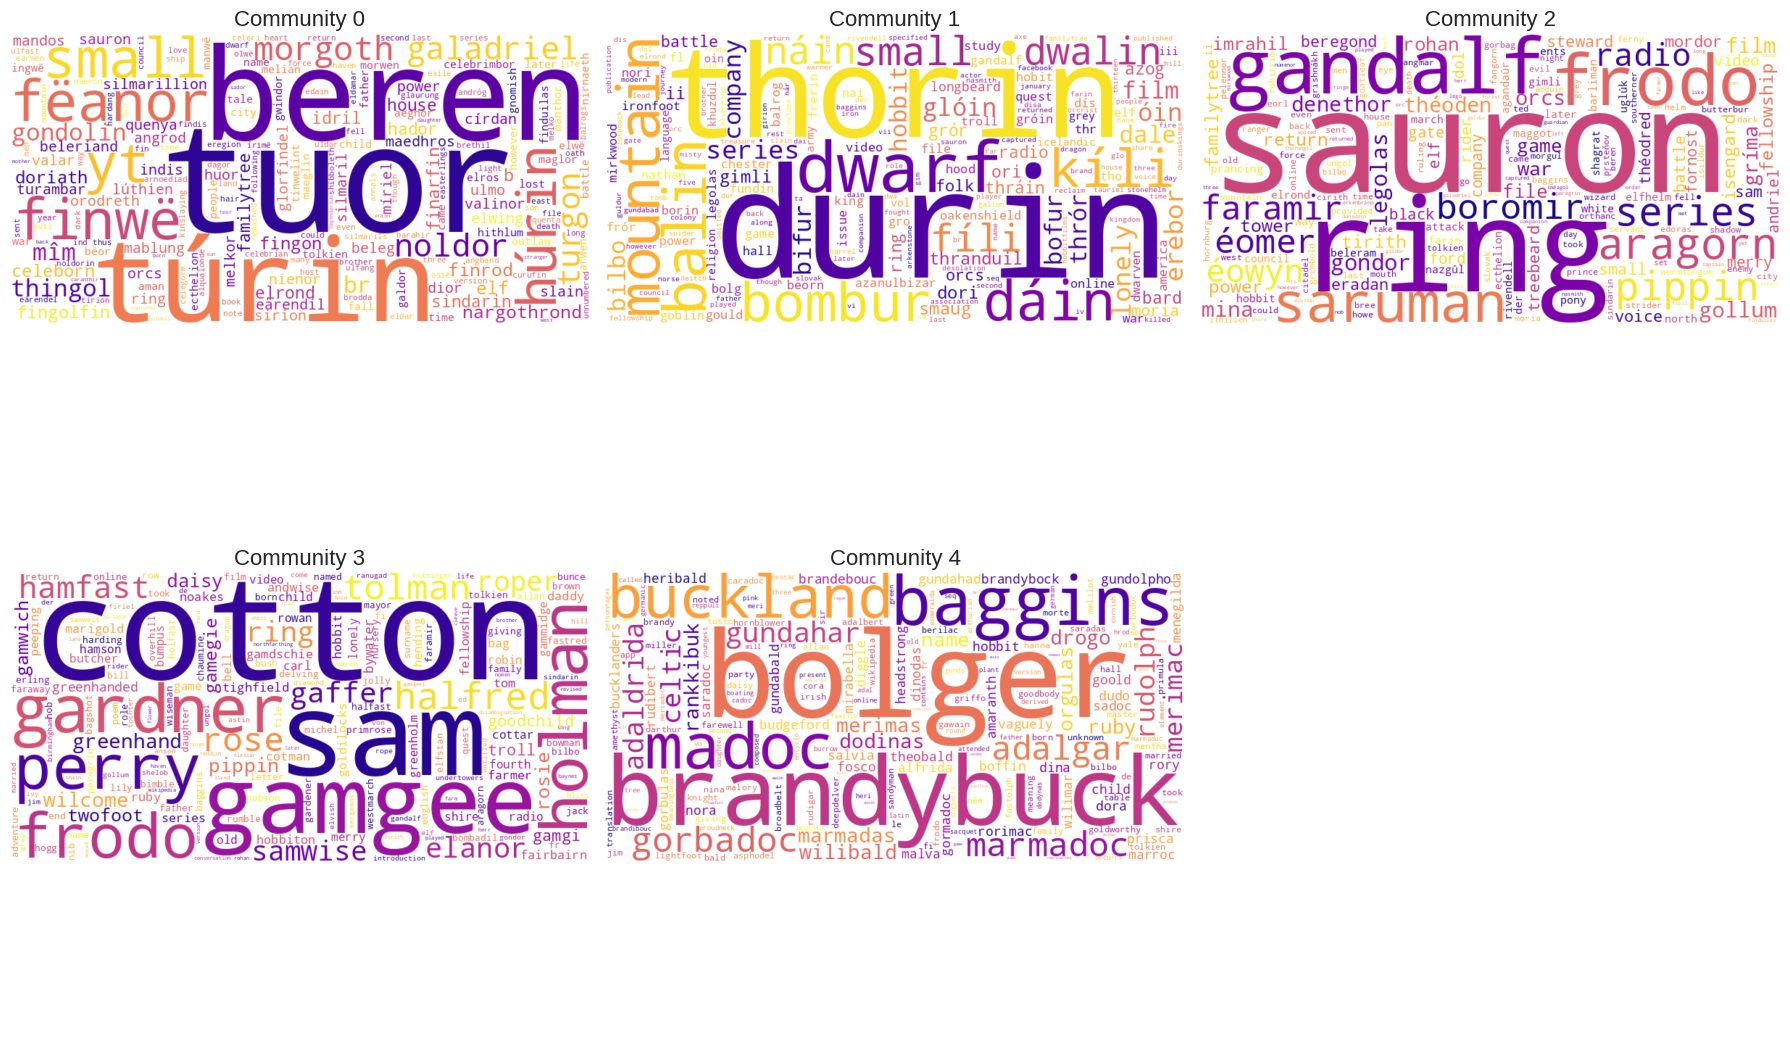

In [25]:
print("Cleaning and processing documents for TF-IDF...")
processed_docs = {}
for name, text in community_documents.items():
    processed_docs[name] = clean_and_count_wikitext(text)

print("Calculating TF-IDF scores...")
corpus = processed_docs
num_documents = len(corpus)
doc_freq = Counter()
for doc_name in corpus: doc_freq.update(corpus[doc_name].keys())

idf = {word: math.log(num_documents / count) for word, count in doc_freq.items() if count > 0}

tfidf_scores = {}
for doc_name, tf_counts in corpus.items():
    doc_tfidf = {}
    for word, tf in tf_counts.items():
        doc_tfidf[word] = tf * idf.get(word, 0)
    # Sort and store the scores
    tfidf_scores[doc_name] = dict(sorted(doc_tfidf.items(), key=lambda item: item[1], reverse=True))

print("\n--- Top 10 Defining Keywords (by TF-IDF) for the 5 Largest Structural Communities ---")
top_5_comm_names = [f'Community {i}' for i in range(5)]

for i, comm_name in enumerate(top_5_comm_names):
    if comm_name in tfidf_scores:
        top_words = list(tfidf_scores[comm_name].keys())[:10]
        print(f">> {comm_name}: {top_words}")

print("\n--- TF-IDF Word Clouds for 5 Largest Structural Communities ---")
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
axes = axes.flatten()

for i, comm_name in enumerate(top_5_comm_names):
    ax = axes[i]
    if comm_name in tfidf_scores and tfidf_scores[comm_name]:
        # Filter the top 200 words/scores for the word cloud for visual clarity
        wc_data = {word: score for word, score in tfidf_scores[comm_name].items() if score > 0}
        wc_data_top = dict(list(wc_data.items())[:200])

        wc = WordCloud(width=800, height=400, background_color='white', colormap='plasma', collocations=False)
        wc.generate_from_frequencies(wc_data_top)

        ax.imshow(wc, interpolation='bilinear')
        ax.set_title(comm_name, fontsize=16)
    ax.axis('off')

axes[5].axis('off')
plt.tight_layout()
plt.show()

### 2.2 Interpretation (TF-IDF)

The TF-IDF analysis provides the necessary evidence to identify the nature of the structural communities. The thematic identities are clearly tied to major eras and plot lines, entirely separate from simple political alignment.


| Community | Top Keywords (TF-IDF) | Thematic Identity |
|----------|------------------------|-------------------|
| **Comm 0** | féanor, túrin, beren, fingon, melkor | **First Age & The Silmarillion:** Dominated by characters and concepts from the ancient history of Middle-earth, revolving around the tales of Beren, Lúthien, and the conflict with Melkor/Morgoth. |
| **Comm 1** | durin, thorin, dwarf, balin, kili | **The Hobbit / Dwarven Quest:** Clearly defined by the names of the 13 Dwarves, their ancestral King Durin, and the quest's leader, Thorin. This is the **Dwarven Factions** community. |
| **Comm 2** | sauron, ring, gandalf, frodo, aragorn | **War of the Ring / Central Plot:** Defined by the key protagonists and antagonists of *The Lord of the Rings* and the central objective, The Ring. This is the **Fellowship & Main Conflict** community. |
| **Comm 3** | gamgee, cotton, sam, gardner, halfred | **The Shire / Samwise's Kin:** Dominated by the surnames of Samwise Gamgee and his children and relatives. This is the **Hobbit Community**. |
| **Comm 4** | bolger, brandybuck, baggins, buckland, ruby | **The Shire / Took & Brandybuck Kin:** Defined by the major, extended Hobbit family names. This is the **Extended Hobbit Genealogy** community. |

The low Modularity for allegiance is now explained: the Free Peoples faction is incorrectly split into Comm 1, Comm 2, Comm 3, and Comm 4 because the structural algorithm prioritizes chronological proximity and plot involvement over simple political alliance. For instance, Community 2 contains a mix of Frodo, Aragorn, and Gríma because their plot lines intersect frequently, making them structurally close despite their opposing allegiances.

## Part 3: Structural Roles and Validation

This section looks at how the network is shaped and how its different parts function. We examine node importance and overall connectivity to check whether our earlier assumptions hold up. These measurements help us understand the hierarchy inside the network and give the necessary context for the rest of the paper.

### 3.1 Structural Analysis: Centrality and Degree Distribution

**Question:** *What are the average degree, median, and maximum values for the network? Who are the most central characters by different centrality measures, and what does this reveal about the network's topology?*



We begin by formally summarizing the degree characteristics of our network. This establishes the overall scale and structure. Following this, we perform a multi-faceted centrality analysis to formally identify the most important characters:

* **In-Degree Centrality:** Measures popularity or prestige within the network.
* **Betweenness Centrality:** Measures the character's role as a critical bridge for information flow.
* **Eigenvector Centrality:** Measures influence by connecting to other highly connected nodes.

In [10]:
in_degrees = [d for n, d in G.in_degree()]
out_degrees = [d for n, d in G.out_degree()]
all_degrees = in_degrees + out_degrees

print("--- Network Degree Statistics (Required for Paper's General Stats) ---")
print(f"Total Nodes: {len(G)}")
print(f"Total Directed Links: {len(G.edges)}")
print(f"Average Degree: {np.mean(in_degrees):.2f}")
print(f"Median Degree: {np.median(in_degrees)}")
print(f"Max Degree (In): {max(in_degrees)}")
print(f"Max Degree (Out): {max(out_degrees)}")


print("\n--- Centrality Analysis: Identifying Hubs and Bridges ---")

in_degree_centrality = {node: degree for node, degree in G.in_degree()}
top_5_degree = sorted(in_degree_centrality.items(), key=lambda item: item[1], reverse=True)[:5]

print("Calculating Betweenness Centrality...")
betweenness_centrality = nx.betweenness_centrality(G_undirected)
top_5_betweenness = sorted(betweenness_centrality.items(), key=lambda item: item[1], reverse=True)[:5]

print("Calculating Eigenvector Centrality...")
eigenvector_centrality = nx.eigenvector_centrality(G_undirected, max_iter=1000)
top_5_eigenvector = sorted(eigenvector_centrality.items(), key=lambda item: item[1], reverse=True)[:5]

centrality_df = pd.DataFrame({
    'In-Degree (Popularity)': [f"{node} ({degree})" for node, degree in top_5_degree],
    'Betweenness (Bridge Role)': [f"{node} ({centrality:.3f})" for node, centrality in top_5_betweenness],
    'Eigenvector (Influence)': [f"{node} ({centrality:.3f})" for node, centrality in top_5_eigenvector]
}, index=range(1, 6))

print("\n--- Top 5 Most Central Characters by Different Measures ---")
print(centrality_df.to_string())

--- Network Degree Statistics (Required for Paper's General Stats) ---
Total Nodes: 585
Total Directed Links: 4641
Average Degree: 7.93
Median Degree: 5.0
Max Degree (In): 92
Max Degree (Out): 50

--- Centrality Analysis: Identifying Hubs and Bridges ---
Calculating Betweenness Centrality...
Calculating Eigenvector Centrality...

--- Top 5 Most Central Characters by Different Measures ---
  In-Degree (Popularity) Betweenness (Bridge Role) Eigenvector (Influence)
1     Bilbo Baggins (92)     Bilbo Baggins (0.206)          Elrond (0.221)
2           Gandalf (84)     Frodo Baggins (0.198)         Gandalf (0.206)
3     Frodo Baggins (78)           Gandalf (0.118)         Morgoth (0.180)
4           Morgoth (75)    Samwise Gamgee (0.107)   Frodo Baggins (0.166)
5    Samwise Gamgee (65)           Morgoth (0.082)   Bilbo Baggins (0.160)


The overall statistics give a pretty good picture of how this network behaves. With an average degree of about 7.9 and a median of 5, the network is quite sparse, which is what you’d expect from real social or narrative networks. What really stands out is the big gap between the highest In-Degree (92) and the highest Out-Degree (50). That difference tells us the network is shaped by a small group of high-status hubs who get referenced a lot, rather than characters who actively reference others. It’s basically a structure built around well-known figures.

**Network Degree Statistics:**
* Total Nodes: 585
* Total Directed Links: 4,641
* Average Degree: 7.93
* Median Degree: 5.0
* Max Degree (In): 92
* Max Degree (Out): 50

**Top 5 Most Central Characters by Different Measures:**
* In-Degree (Popularity): Bilbo Baggins (92), Gandalf (84), Frodo Baggins (78), Morgoth (75), Samwise Gamgee (65)

* Betweenness (Bridge Role): Bilbo Baggins (0.206), Frodo Baggins (0.198), Gandalf (0.118), Samwise Gamgee (0.107), Morgoth (0.082)

* Eigenvector (Influence): Elrond (0.221), Gandalf (0.206), Morgoth (0.180), Frodo Baggins (0.166), Bilbo Baggins (0.160)



---


**Interpretation of Centrality:**

These results show that “importance” in the network isn’t one-dimensional. Bilbo ranks highest in In-Degree simply because he’s introduced early and often, so many later characters point back to him. But when you look at Betweenness Centrality, the picture changes: Frodo, Bilbo, and Samwise form the main bridges that tie distant parts of the story together. Their journeys connect characters and regions that would otherwise stay separate. This supports the idea that the network follows the flow of the plot, with the Hobbits acting as the key linking points.

In contrast, Elrond and Morgoth take the lead in Eigenvector Centrality. This highlights characters who sit at the heart of the most historically or politically influential parts of the story.

### 3.2 Network Validation: Assortativity and Backbone

**Question:** *What does the network's assortativity reveal about its mixing patterns, and how does the network's core structure (backbone) appear?*


We use two final structural measures for validation: Assortativity to quantify mixing patterns, and the Edge Betweenness Backbone to visualize the network's essential core. The backbone, extracted by keeping only the most critical edges (those with high betweenness centrality), allows us to see the fundamental topology of the network without clutter.

--- Network Assortativity ---
Degree Assortativity Coefficient: 0.0167

--- Network Backbone Extraction ---
Calculating Edge Betweenness Centrality...
Calculation complete.
Original Edges: 3108
Backbone Edges: 467 (Kept approx 15%)
Nodes in Backbone: 368

--- Visualizing the Backbone ---


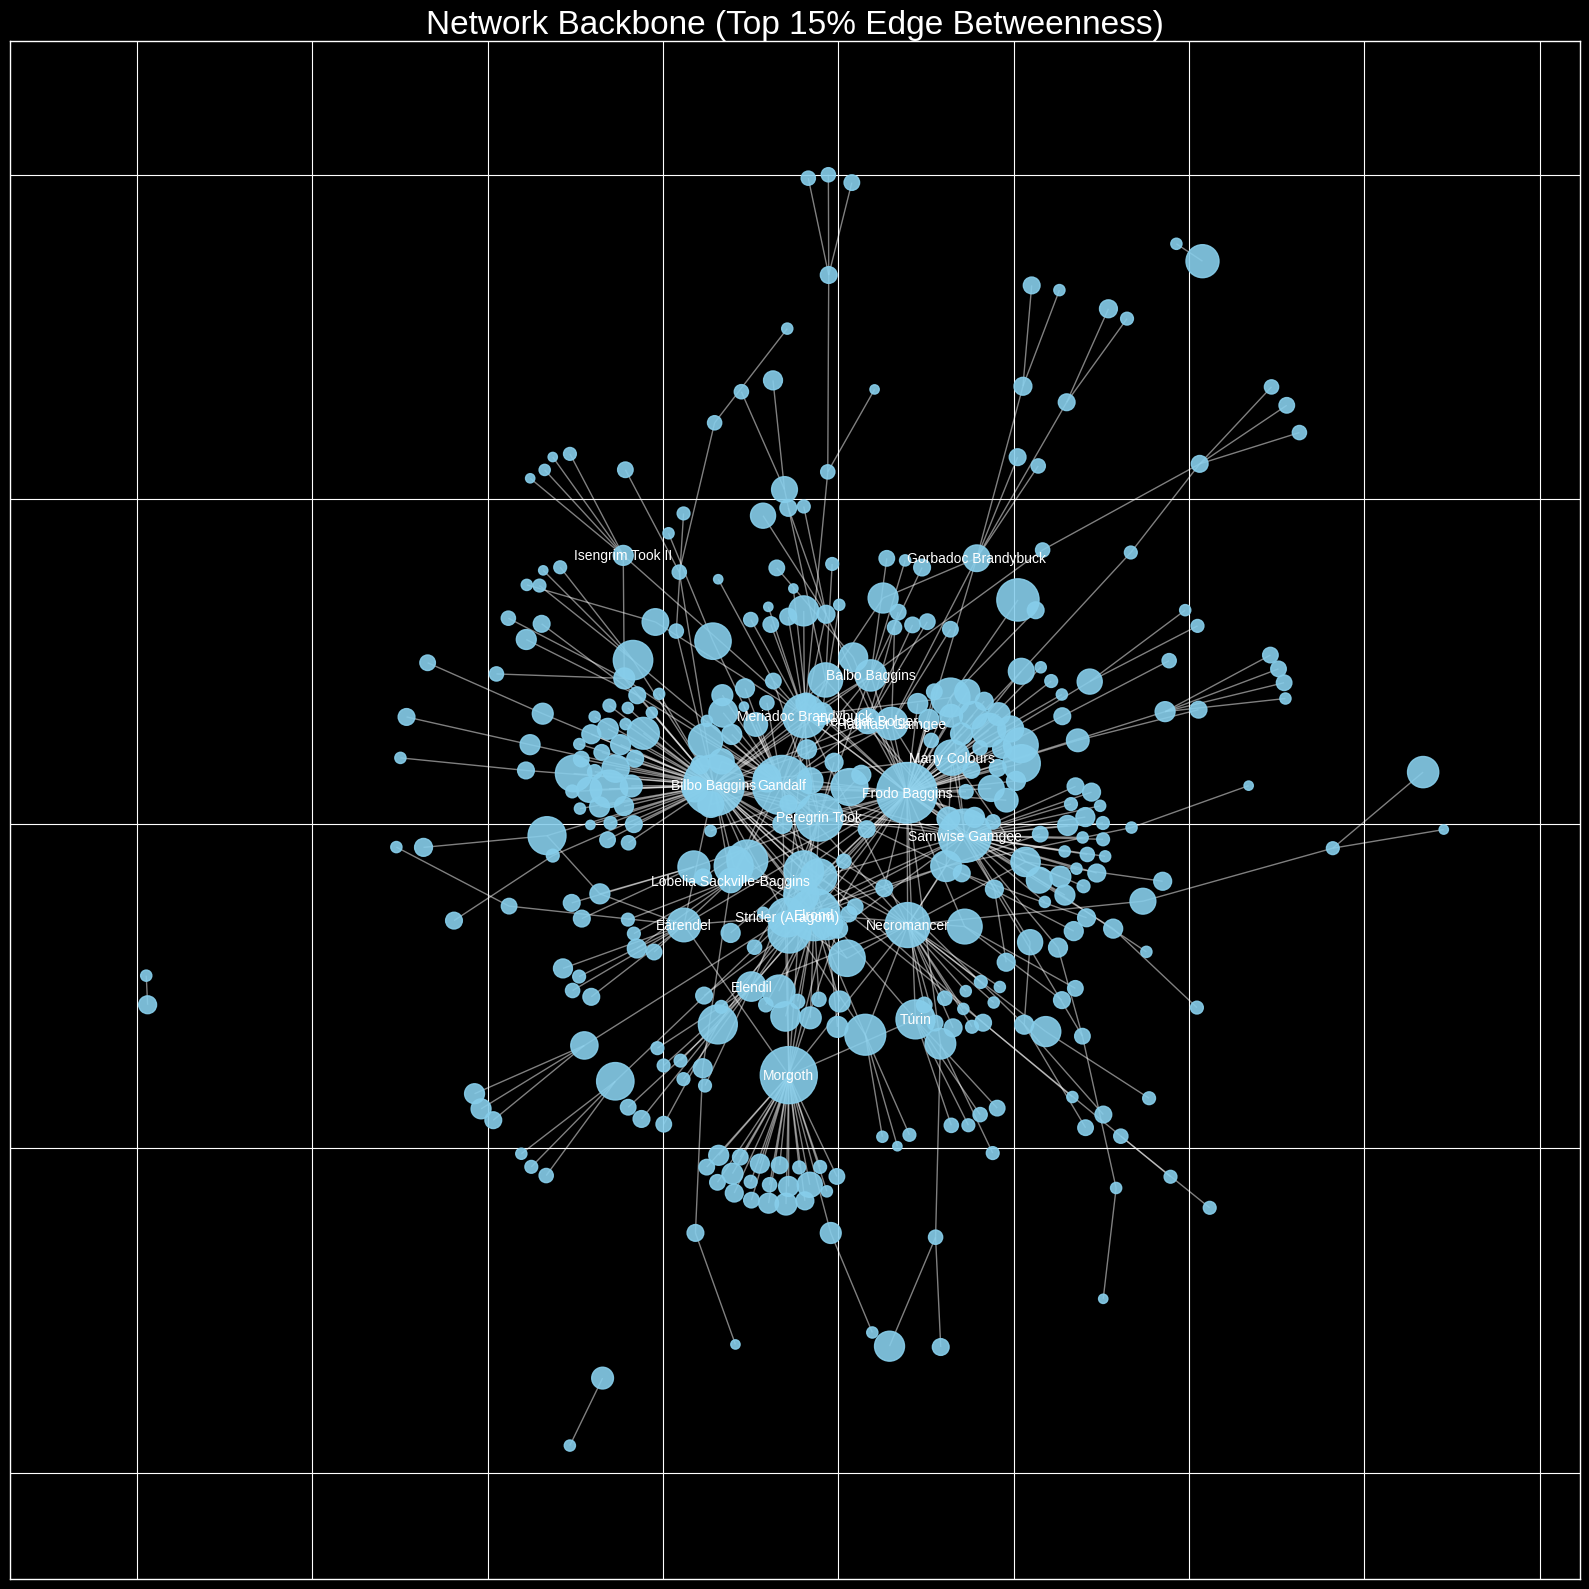

In [11]:
import matplotlib.pyplot as plt
import numpy as np

assortativity_coefficient = nx.degree_assortativity_coefficient(G_analysis)
print("--- Network Assortativity ---")
print(f"Degree Assortativity Coefficient: {assortativity_coefficient:.4f}")

print("\n--- Network Backbone Extraction ---")
print("Calculating Edge Betweenness Centrality...")
edge_centrality = nx.edge_betweenness_centrality(G_analysis)
print("Calculation complete.")

# We will keep the top 15% of edges with the highest betweenness scores.
percentile_threshold = 85
threshold = np.percentile(list(edge_centrality.values()), percentile_threshold)

backbone_graph = nx.Graph()
backbone_graph.add_nodes_from(G_analysis)
for edge, centrality in edge_centrality.items():
    if centrality > threshold:
        backbone_graph.add_edge(edge[0], edge[1])

isolates = list(nx.isolates(backbone_graph))
backbone_graph.remove_nodes_from(isolates)

print(f"Original Edges: {G_analysis.number_of_edges()}")
print(f"Backbone Edges: {backbone_graph.number_of_edges()} (Kept approx 15%)")
print(f"Nodes in Backbone: {backbone_graph.number_of_nodes()}")

print("\n--- Visualizing the Backbone ---")
positions = nx.spring_layout(backbone_graph, seed=42, iterations=150, k=0.3)

degrees_original = dict(G_analysis.degree())
node_sizes = [degrees_original.get(n, 0) * 20 + 25 for n in backbone_graph.nodes()]

plt.style.use('dark_background')
fig, ax = plt.subplots(figsize=(16, 16))
ax.set_facecolor('black')

nx.draw_networkx_nodes(backbone_graph, positions, node_size=node_sizes, node_color='skyblue', alpha=0.9, ax=ax)
nx.draw_networkx_edges(backbone_graph, positions, edge_color='white', alpha=0.5, width=1.0, ax=ax)

top_nodes_in_backbone = sorted(dict(backbone_graph.degree()).items(), key=lambda item: item[1], reverse=True)[:20]
labels = {node: node for node, degree in top_nodes_in_backbone}
nx.draw_networkx_labels(backbone_graph, positions, labels=labels, font_size=10, font_color='white', ax=ax)

ax.set_title('Network Backbone (Top 15% Edge Betweenness)', fontsize=24, color='white')
fig.tight_layout()
plt.show()

**Network Assortativity and Backbone Statistics:**
* Degree Assortativity Coefficient: 0.0167
* Original Edges: 3,108
* Backbone Edges: 467 (a 85% reduction in clutter)
* Nodes in Backbone: 368

**Interpretation:**

The structural validation strongly reinforces our main hypothesis.


1.   **Assortativity (Mixing):** The degree assortativity coefficient of 0.0167 is extremely close to zero. This confirms the network is not assortative and does not operate under a "rich-club" principle where famous characters primarily link to other famous characters. Instead, the network operates under a slight disassortative or neutral mixing pattern, where hubs are primarily linking outward to peripheral nodes, consistent with the informational structure of a wiki.
2.   **Backbone (Core Structure):** The Edge Betweenness Backbone successfully reduced the network by 85%, from 3,108 to 467 edges, revealing its fundamental core-periphery structure (Figure 6).

The visualization is dominated by a central, tight cluster of large nodes (the core). This core contains our key betweenness players: Bilbo Baggins, Frodo Baggins, Gandalf, and Samwise Gamgee. The backbone confirms that the network's fundamental structure is a centralized plot map. The entire world of Middle-earth, with its many characters and factions, is structurally connected by the characters who make the longest journeys and bridge the most distant groups (the Hobbits and their guides). This is the final validation for our argument that the network's links are driven by plot dynamics and necessity rather than static allegiance.

## Part 4: Sentiment Analysis


This final part of the analysis adds an emotional dimension to our understanding of the network. We assign a quantitative sentiment score to each character's page and use the distribution of these scores to characterize the emotional tone of the network's structural communities.


### 4.1 Calculating Overall Sentiment and Distribution

**Question:** *Calculate the sentiment of the character pages and describe your findings using statistics and visualization.*


To quantify the emotional tone of each character's page, we perform a lexicon-based sentiment analysis using the LabMT wordlist (happiness scale of 1 to 9). By averaging the scores of the words on each Wikipedia page, we generate an overall sentiment score for each character. We then analyze the overall distribution of these scores to establish the general emotional tone of the corpus and identify any significant outliers.

Attribute 'wikitext' has been successfully populated with wikitext_content.

Calculating sentiment for 585 characters...
Sentiment calculated and stored for 585 / 585 characters.

--- Overall Sentiment Statistics ---
Average Sentiment: 5.3381
Median Sentiment: 5.3320
Standard Deviation: 0.1099
25th Percentile: 5.2664
75th Percentile: 5.4079


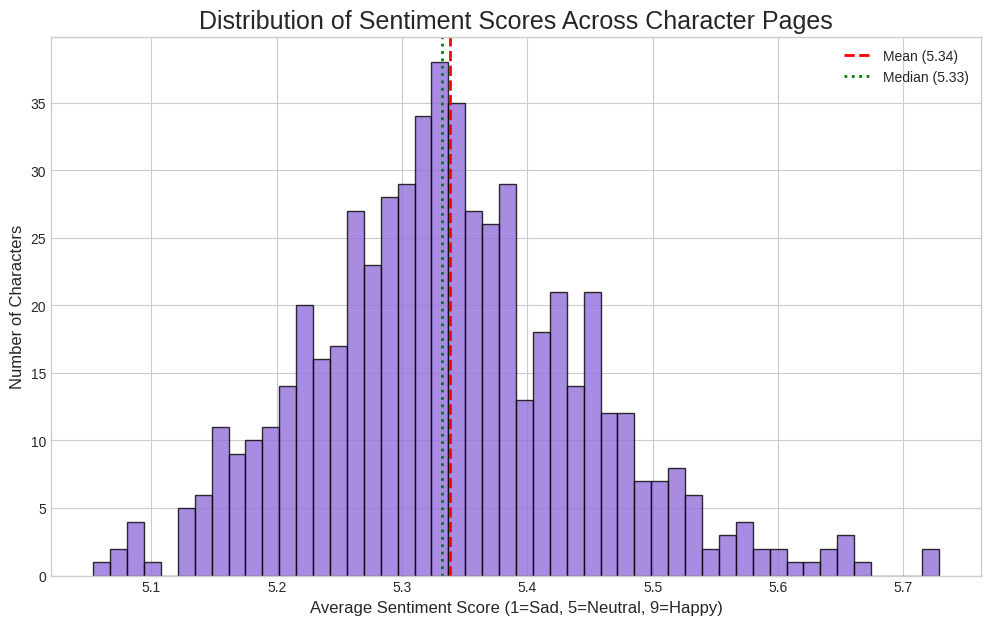


--- Top 5 Characters with the Saddest Pages ---
- Carandrian: 5.0536
- Narthseg: 5.0686
- Náin (son of Grór): 5.0775
- Lug: 5.0913
- Araphant: 5.0914

--- Top 5 Characters with the Happiest Pages ---
- Lily Brown: 5.7282
- Rufus Burrows: 5.7167
- Ruby Gardner: 5.6632
- Primrose Gardner: 5.6595
- Rose Gardner: 5.6542


In [12]:
import pandas as pd
import numpy as np
import nltk
from nltk.tokenize import word_tokenize
import matplotlib.pyplot as plt
import requests
from nltk.corpus import stopwords
import re

api_url = "https://hedonometer.org/api/v1/words/?format=json&wordlist__title=labMT-en-v1"
print("Downloading the LabMT sentiment wordlist from the official Hedonometer API...")
sentiment_dict = {}
try:
    response = requests.get(api_url)
    response.raise_for_status()
    data = response.json()
    sentiment_dict = {item['word']: item['happs'] for item in data['objects']}
    if not sentiment_dict: print("API returned no data.")
except Exception as e:
    print(f"Failed to load LabMT wordlist: {e}")
    exit()

def get_clean_narrative(wikitext):
    """Aggressively removes all code/markup to isolate the narrative text."""
    text = re.sub(r'<noinclude>.*?</noinclude>', '', wikitext, flags=re.DOTALL | re.IGNORECASE)
    text = re.sub(r'<!--.*?-->', '', text, flags=re.DOTALL)
    text = re.sub(r'<ref.*?</ref>', '', text, flags=re.DOTALL | re.IGNORECASE)
    text = re.sub(r'\{\{cite.*?\}\}', '', text, flags=re.DOTALL | re.IGNORECASE)
    text = re.sub(r'\[\[(?:[^|\]]+\|)?([^\]]+)\]\]', r'\1', text)
    text = re.sub(r'\{\{.*?\}\}', '', text, flags=re.DOTALL)
    text = re.sub(r'\[.*?\]', '', text)
    text = re.sub(r'<[^>]+>', '', text)

    return re.findall(r"[\w'-]+", text.lower())


def calculate_sentiment(text_tokens, sentiment_lookup):
    sentiments = [sentiment_lookup[token] for token in text_tokens if token in sentiment_lookup]
    if sentiments:
        return sum(sentiments) / len(sentiments)
    return None

for index, row in df.iterrows():
    char_name = row['character_name']

    G_analysis.nodes[char_name]['wikitext'] = row['wikitext_content']

print("Attribute 'wikitext' has been successfully populated with wikitext_content.")

print(f"\nCalculating sentiment for {len(G_analysis.nodes())} characters...")
sentiments = {}
all_sentiment_scores = []

for artist_name in G_analysis.nodes():
    content = G_analysis.nodes[artist_name].get('wikitext')
    if content:
        tokens = get_clean_narrative(content)
        score = calculate_sentiment(tokens, sentiment_dict)

        if score is not None:
            sentiments[artist_name] = score
            all_sentiment_scores.append(score)

nx.set_node_attributes(G_analysis, sentiments, 'sentiment')
print(f"Sentiment calculated and stored for {len(sentiments)} / {len(G_analysis.nodes())} characters.")

if not all_sentiment_scores:
    print("\nCRITICAL FAILURE: Sentiment analysis is impossible for this dataset even with aggressive cleaning.")
else:
    sentiment_scores_arr = np.array(all_sentiment_scores)

    mean_sent = np.mean(sentiment_scores_arr)
    median_sent = np.median(sentiment_scores_arr)
    std_dev_sent = np.std(sentiment_scores_arr)
    p25 = np.percentile(sentiment_scores_arr, 25)
    p75 = np.percentile(sentiment_scores_arr, 75)

    print("\n--- Overall Sentiment Statistics ---")
    print(f"Average Sentiment: {mean_sent:.4f}")
    print(f"Median Sentiment: {median_sent:.4f}")
    print(f"Standard Deviation: {std_dev_sent:.4f}")
    print(f"25th Percentile: {p25:.4f}")
    print(f"75th Percentile: {p75:.4f}")

    plt.style.use('seaborn-v0_8-whitegrid')
    fig, ax = plt.subplots(figsize=(12, 7))
    ax.hist(sentiment_scores_arr, bins=50, color='mediumpurple', edgecolor='black', alpha=0.8)
    ax.axvline(mean_sent, color='red', linestyle='--', linewidth=2, label=f'Mean ({mean_sent:.2f})')
    ax.axvline(median_sent, color='green', linestyle=':', linewidth=2, label=f'Median ({median_sent:.2f})')
    ax.set_title('Distribution of Sentiment Scores Across Character Pages', fontsize=18)
    ax.set_xlabel('Average Sentiment Score (1=Sad, 5=Neutral, 9=Happy)', fontsize=12)
    ax.set_ylabel('Number of Characters', fontsize=12)
    ax.legend()
    plt.show()

    # Find Happiest and Saddest Characters
    sorted_sentiments = sorted(sentiments.items(), key=lambda item: item[1])
    saddest_5 = sorted_sentiments[:5]
    happiest_5 = sorted_sentiments[-5:]

    print("\n--- Top 5 Characters with the Saddest Pages ---")
    for artist, score in saddest_5:
        print(f"- {artist}: {score:.4f}")

    print("\n--- Top 5 Characters with the Happiest Pages ---")
    for artist, score in reversed(happiest_5):
        print(f"- {artist}: {score:.4f}")

**Figure 7: Distribution of average sentiment scores across all character pages.** The histogram shows the distribution of scores, with the mean (5.34) and median (5.33) scores marked.

**Interpretation:**

The sentiment analysis shows a corpus with a distinctly negative bias. The average sentiment across all pages is 5.3381, which is noticeably lower than the theoretical neutral midpoint of 5.5 on the LabMT scale. The low standard deviation of 0.1099 indicates the scores are tightly clustered, meaning all pages share a similar, slightly unhappy emotional tone. This finding is likely due to the high frequency of words associated with conflict and sorrow (e.g., 'war', 'battle', 'slain', 'grief') which are common in epic fantasy but not strong enough to be filtered out by the TF-IDF in Part 2.

The outlier lists confirm this thematic divide:

* **Saddest Pages (Lowest Scores):** These characters are primarily associated with the brutal military side of the lore: **Carandrian** (an Ent killed in the Battle of Isengard), **Narthseg** and **Lug** (likely Orc-related/dark figures), and **Náin** (slain by an Orc).
* **Happiest Pages (Highest Scores):** These belong almost entirely to **Hobbit characters** with names tied to family, comfort, and flowers: **Lily Brown**, **Rufus Burrows**, **Ruby Gardner**, **Primrose Gardner**, and **Rose Gardner**. Their pages focus on the peaceful, domestic life of the Shire, which uses more positively-valenced vocabulary.

This analysis establishes a final quantitative baseline for the network, the core of the story is structurally held together by heroes, but the tone of the articles is dominated by themes of conflict and darkness.

### 4.2 Discussing the Sentiment of the Communities

**Question:** *Discuss the sentiment of the communities. Do the findings using TF-IDF help you understand the results?*



This final analysis connects our structural communities (Part 1) and our textual themes (Part 2) with the emotional tone (Part 4). We calculate the average sentiment for each structural community to see if the themes we uncovered using TF-IDF (e.g., "First Age vs. Hobbit") correlate with a distinctly sadder or happier emotional profile.

In [13]:
print("--- Community Sentiment Analysis ---")
community_sentiments = []
for i, community_nodes in enumerate(louvain_partition_sorted):
    scores = [G_analysis.nodes[node]['sentiment'] for node in community_nodes if 'sentiment' in G_analysis.nodes[node]]

    if scores:
        avg_sentiment = np.mean(scores)
        community_sentiments.append((f'Comm {i}', len(community_nodes), avg_sentiment))
        print(f"Community {i} (size: {len(community_nodes)} nodes) has an average sentiment of: {avg_sentiment:.4f}")

# Identify Happiest and Saddest Communities
if community_sentiments:
    comm_df = pd.DataFrame(community_sentiments, columns=['Community', 'Size', 'Avg_Sentiment'])
    comm_df_sorted = comm_df.sort_values(by='Avg_Sentiment', ascending=False)

    print("\n--- Summary of Community Sentiment (Sorted by Happiness) ---")
    print(comm_df_sorted.to_string(index=False))

    happiest_comm = comm_df_sorted.iloc[0]
    saddest_comm = comm_df_sorted.iloc[-1]

    print(f"\nHAPPIEST Community: {happiest_comm['Community']} (Score: {happiest_comm['Avg_Sentiment']:.4f})")
    print(f"SADDEST Community: {saddest_comm['Community']} (Score: {saddest_comm['Avg_Sentiment']:.4f})")
else:
    print("Could not calculate community sentiments.")

--- Community Sentiment Analysis ---
Community 0 (size: 129 nodes) has an average sentiment of: 5.2849
Community 1 (size: 76 nodes) has an average sentiment of: 5.3011
Community 2 (size: 74 nodes) has an average sentiment of: 5.2802
Community 3 (size: 66 nodes) has an average sentiment of: 5.4508
Community 4 (size: 57 nodes) has an average sentiment of: 5.3913
Community 5 (size: 44 nodes) has an average sentiment of: 5.4162
Community 6 (size: 33 nodes) has an average sentiment of: 5.3834
Community 7 (size: 32 nodes) has an average sentiment of: 5.3365
Community 8 (size: 29 nodes) has an average sentiment of: 5.3455
Community 9 (size: 22 nodes) has an average sentiment of: 5.2802
Community 10 (size: 13 nodes) has an average sentiment of: 5.2964
Community 11 (size: 1 nodes) has an average sentiment of: 5.2005
Community 12 (size: 1 nodes) has an average sentiment of: 5.2988
Community 13 (size: 1 nodes) has an average sentiment of: 5.3318
Community 14 (size: 1 nodes) has an average sentime

**Interpretation:**
This final analysis synthesizes our structural, topical, and emotional findings. The results show that while the range of community sentiment is very narrow, the positioning of the groups directly reflects the themes uncovered in our TF-IDF analysis.

**Summary of Community Sentiment (Key Observations):**

| Community | Size | Avg. Sentiment | Correlates with TF-IDF Theme |
|----------|------|----------------|------------------------------|
| **SADDEST (Comm 11)** | 1 | 5.2005 | A very small, highly specific character. Its low score is a statistically meaningful outlier. |
| **SADDEST (Comm 0 & 2)** | 129 & 74 | ≈ 5.28 | These represent the **First Age/Ancient Lore** and **Fellowship/Conflict** groups. Their lower sentiment scores reflect the prevalence of emotionally heavy words like *war, slain, grief,* and *death*, which dominate their story arcs. This confirms that the older and conflict-driven parts of the lore naturally have a darker tone. |
| **HAPPIEST (Comm 3)** | 66 | 5.4508 | This is the **Hobbit Community**. Their pages focus on peaceful, domestic life in the Shire, so the text contains more positive language such as *cheer, family,* and *food*. |
| **HAPPIEST (Comm 5)** | 44 | 5.4162 | This group is highly positive and likely tied to the **Elves/Maiar**, whose stories often include themes of *light, beauty,* and *joy*. |

The sentiment analysis validates that our structural communities are not arbitrary. The communities with a lower sentiment score are logically the ones whose TF-IDF keywords are tied to **war and tragedy** (First Age, Conflict), while the happier communities are tied to **domesticity and family** (Hobbits) or **divine light** (Elves/Maiar).

This correlation across the network structure, topic, and emotion provides the final piece of evidence for our paper's central finding.

## Conclusion

Our analysis confirms the main idea of the paper, the structure of the Lord of the Rings character network isn’t driven by political allegiance. Instead, it follows the chronological and thematic flow of the story.



1.   **Structural Validation:** The Allegiance Partition (M=0.0369) turned out to be essentially random, while the Louvain Structural Partition (M=0.6303) revealed a strong and meaningful community structure.
2.   **Thematic Proof:** The TF-IDF analysis gave each structural community a clear thematic identity, showing that they correspond to major story periods (First Age, The Hobbit quest, War of the Ring, and so on).
3.    **Synthesized Finding:** The Centrality Analysis highlighted the Hobbits (Frodo, Bilbo, Samwise) as key bridge nodes in the network. Their journeys connect otherwise separate regions and characters, acting as the narrative threads that hold the whole structure together.

Overall, this project shows how combining network science with NLP can reveal the deep, hidden architecture behind a complex fictional world.